Writer: Yinbo Song
Email: songyinbo@outlook.com
Date: 2023.07.03

In [1]:
%reset -f
import numpy as np
import pandas as pd
%clear

# 1 Import the results of photogrammetry， including the sparse point clouds before and after deformation
points = pd.read_excel('data\zxt_300Pa.xlsx', sheet_name = 'points')
points_deformed = pd.read_excel('data\zxt_13000Pa.xlsx', sheet_name = 'points') # Change the file name to obtain different results

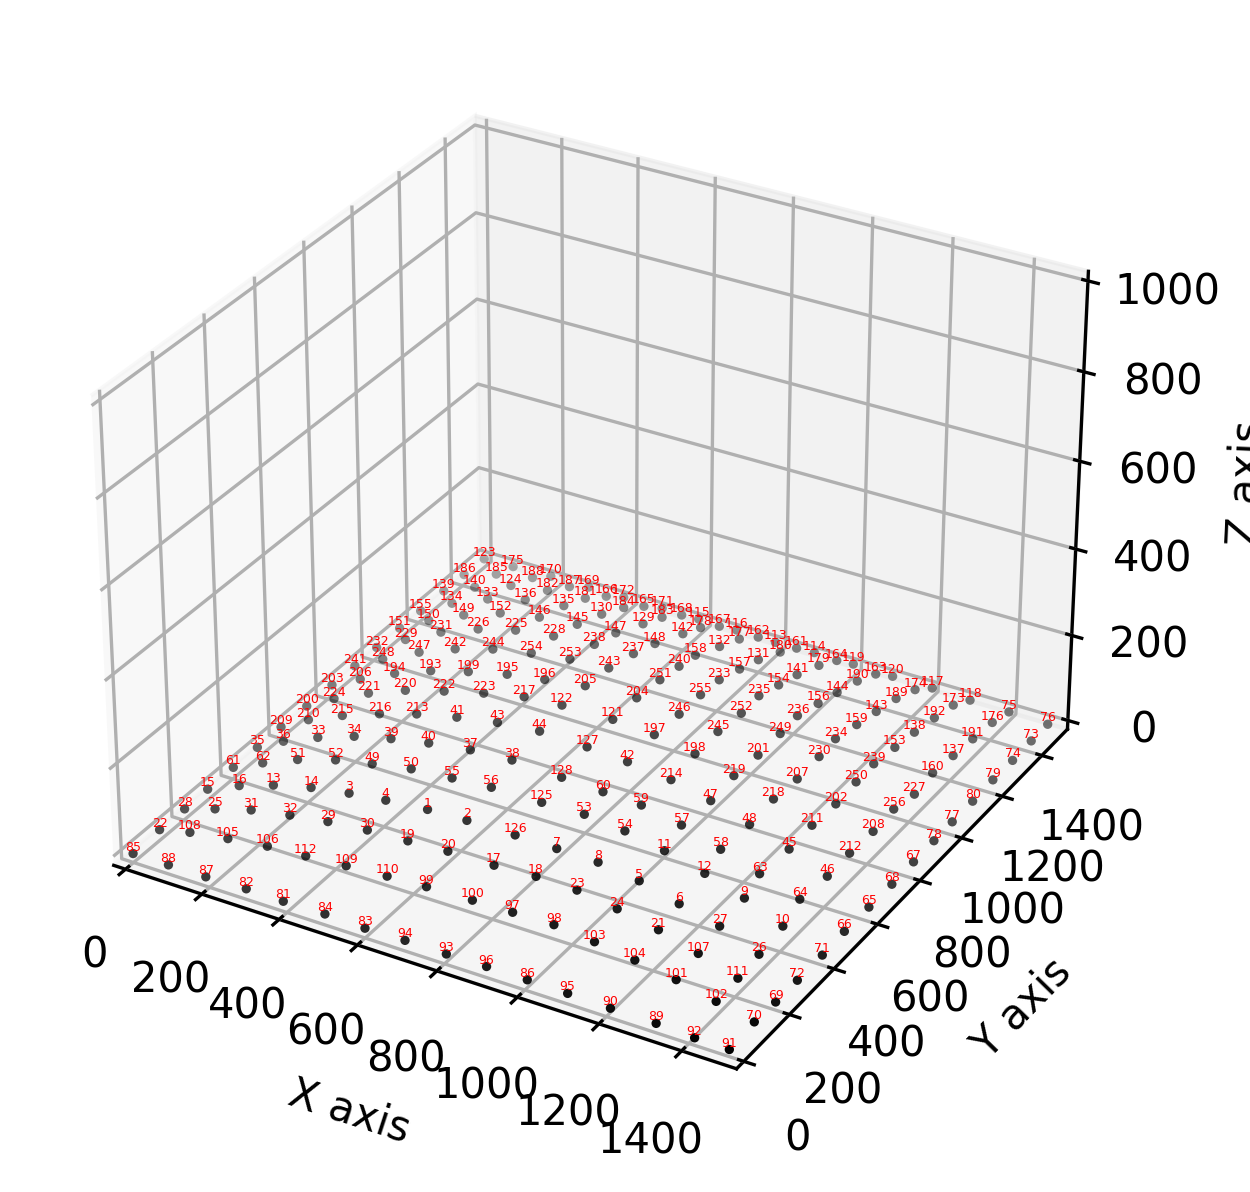

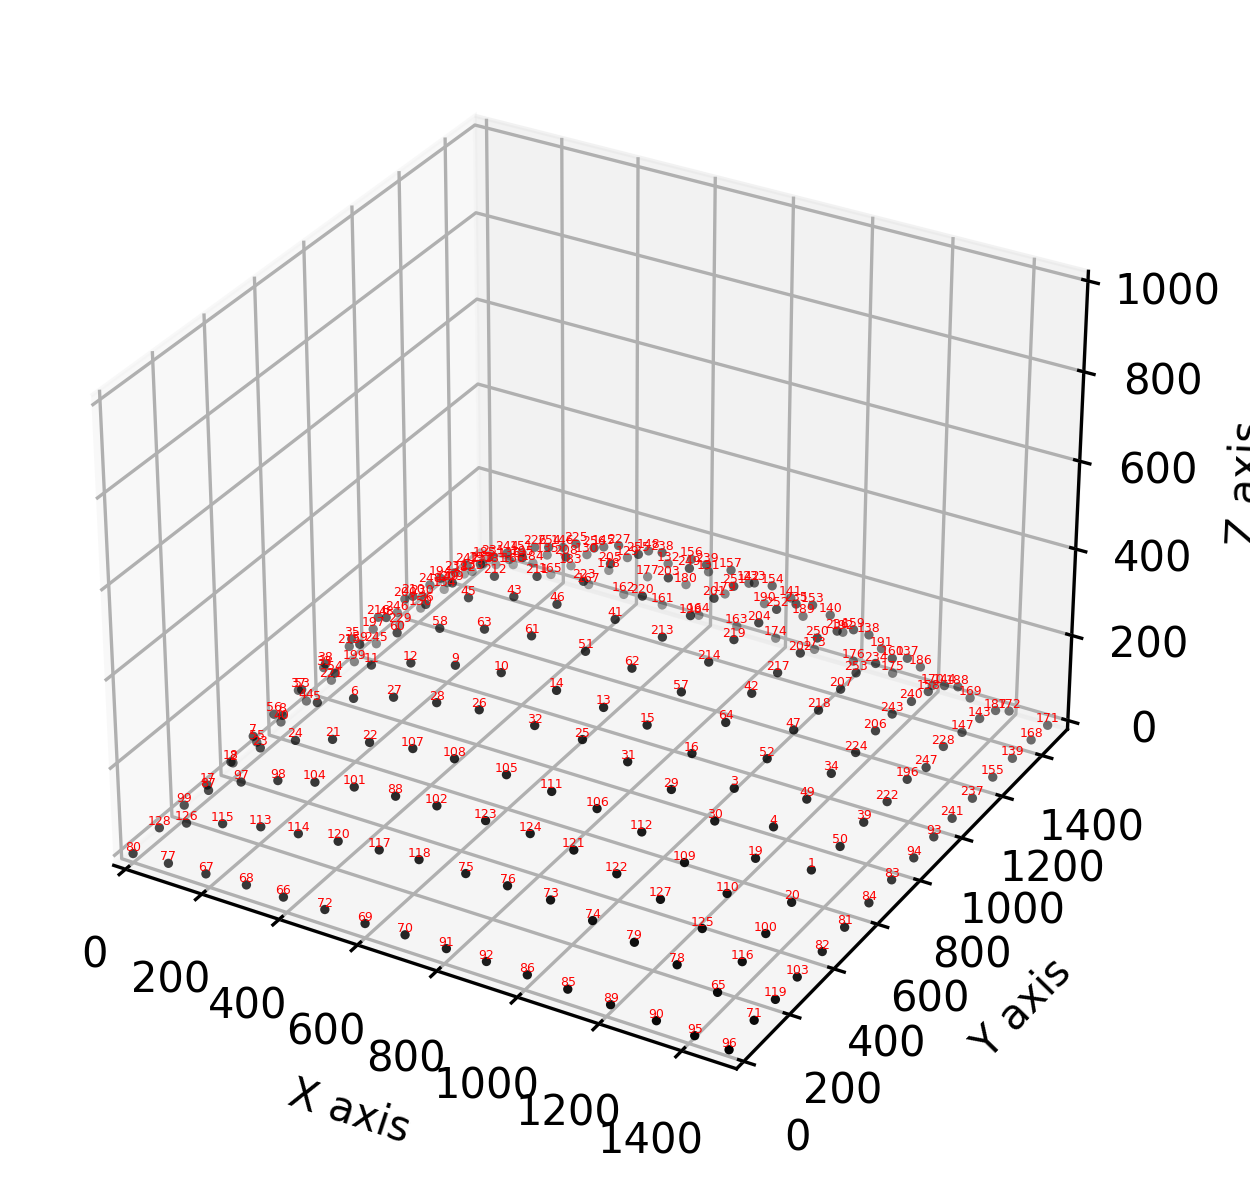

In [2]:
# 1.1 Check the sparse point cloud before deformation
from matplotlib import pyplot as plt
plt.close("all")
from mpl_toolkits.mplot3d import axes3d
plt.figure(dpi=300)
ax = plt.axes(projection = '3d')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
ax.set_zlim(0, 1000)
ax.scatter(points['point_x'], points['point_y'], points['point_z'], s = 5,
    color = 'k', 
    marker = 'o',
    linewidths=0)
ax.set_xlabel('X axis') 
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
for i in range(points.shape[0]):
    ax.text(points['point_x'][i], points['point_y'][i], points['point_z'][i],
            points['point_ID'][i],
            fontsize = 3,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

# 1.2 Check the sparse point cloud after deformation
plt.figure(dpi=300)
ax = plt.axes(projection = '3d')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
ax.set_zlim(0, 1000)
ax.scatter(points_deformed['point_x'], points_deformed['point_y'], points_deformed['point_z'], s = 5,
    color = 'k', 
    marker = 'o',
    linewidths=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
for i in range(len(points_deformed['point_ID'])):
    ax.text(points_deformed['point_x'][i], points_deformed['point_y'][i], points_deformed['point_z'][i],
            points_deformed['point_ID'][i],
            fontsize = 3,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')
del ax, i

The following code block requires the number of rows and columns of the target posted on the membrane surface:

In [3]:
# 2 Recode the point clouds
# 2.1 Recode the point cloud before deformation
points = points.sort_values(by='point_y') # Sort the points in ascending order by y-coordinates
group = [] # Create an empty list for each row of data
points_new = pd.DataFrame() # Create an empty Dataframe to save the sorted point coordinates and numbers
num_rowx = 16 # Number of rows in x-direction
num_rowy = 16 # Number of rows in Y-direction
for i in range(num_rowx):
        group.append(points.iloc[num_rowy * i : num_rowy * (i + 1), ]) # Grouping the sorted y-coordinates
        group[i] = group[i].sort_values(by='point_x') # Sort the points in each group in ascending order by x-coordinate
        #points_new = points_new.append(group[i]) # Recombine the sorted sets of points into a new set of points
        points_new = pd.concat([points_new, group[i]], ignore_index=True)

points_new = points_new.reset_index(drop=True) # Reset index value
for i in range(len(points_new['point_ID'])):
        points_new.loc[i, 'point_ID'] = i # Assign the index value to the dot
points = points_new
del points_new, group

# 2.2 Recode the point cloud after deformation
num_rowx = 16 # Number of rows in x-direction
num_rowy = 16 # Number of rows in Y-direction
points_deformed = points_deformed.sort_values(by='point_y')
group = []
points_deformed_new = pd.DataFrame()
for i in range(num_rowx):
        group.append(points_deformed.iloc[num_rowy * i : num_rowy * (i + 1), ])
        group[i] = group[i].sort_values(by='point_x')
        #points_deformed_new = points_deformed_new.append(group[i])
        points_deformed_new = pd.concat([points_deformed_new, group[i]], ignore_index=True)
points_deformed_new = points_deformed_new.reset_index(drop=True)
for i in range(len(points_deformed_new['point_ID'])):
        points_deformed_new.loc[i, 'point_ID'] = i
points_deformed = points_deformed_new
del points_deformed_new, group, i, num_rowx, num_rowy

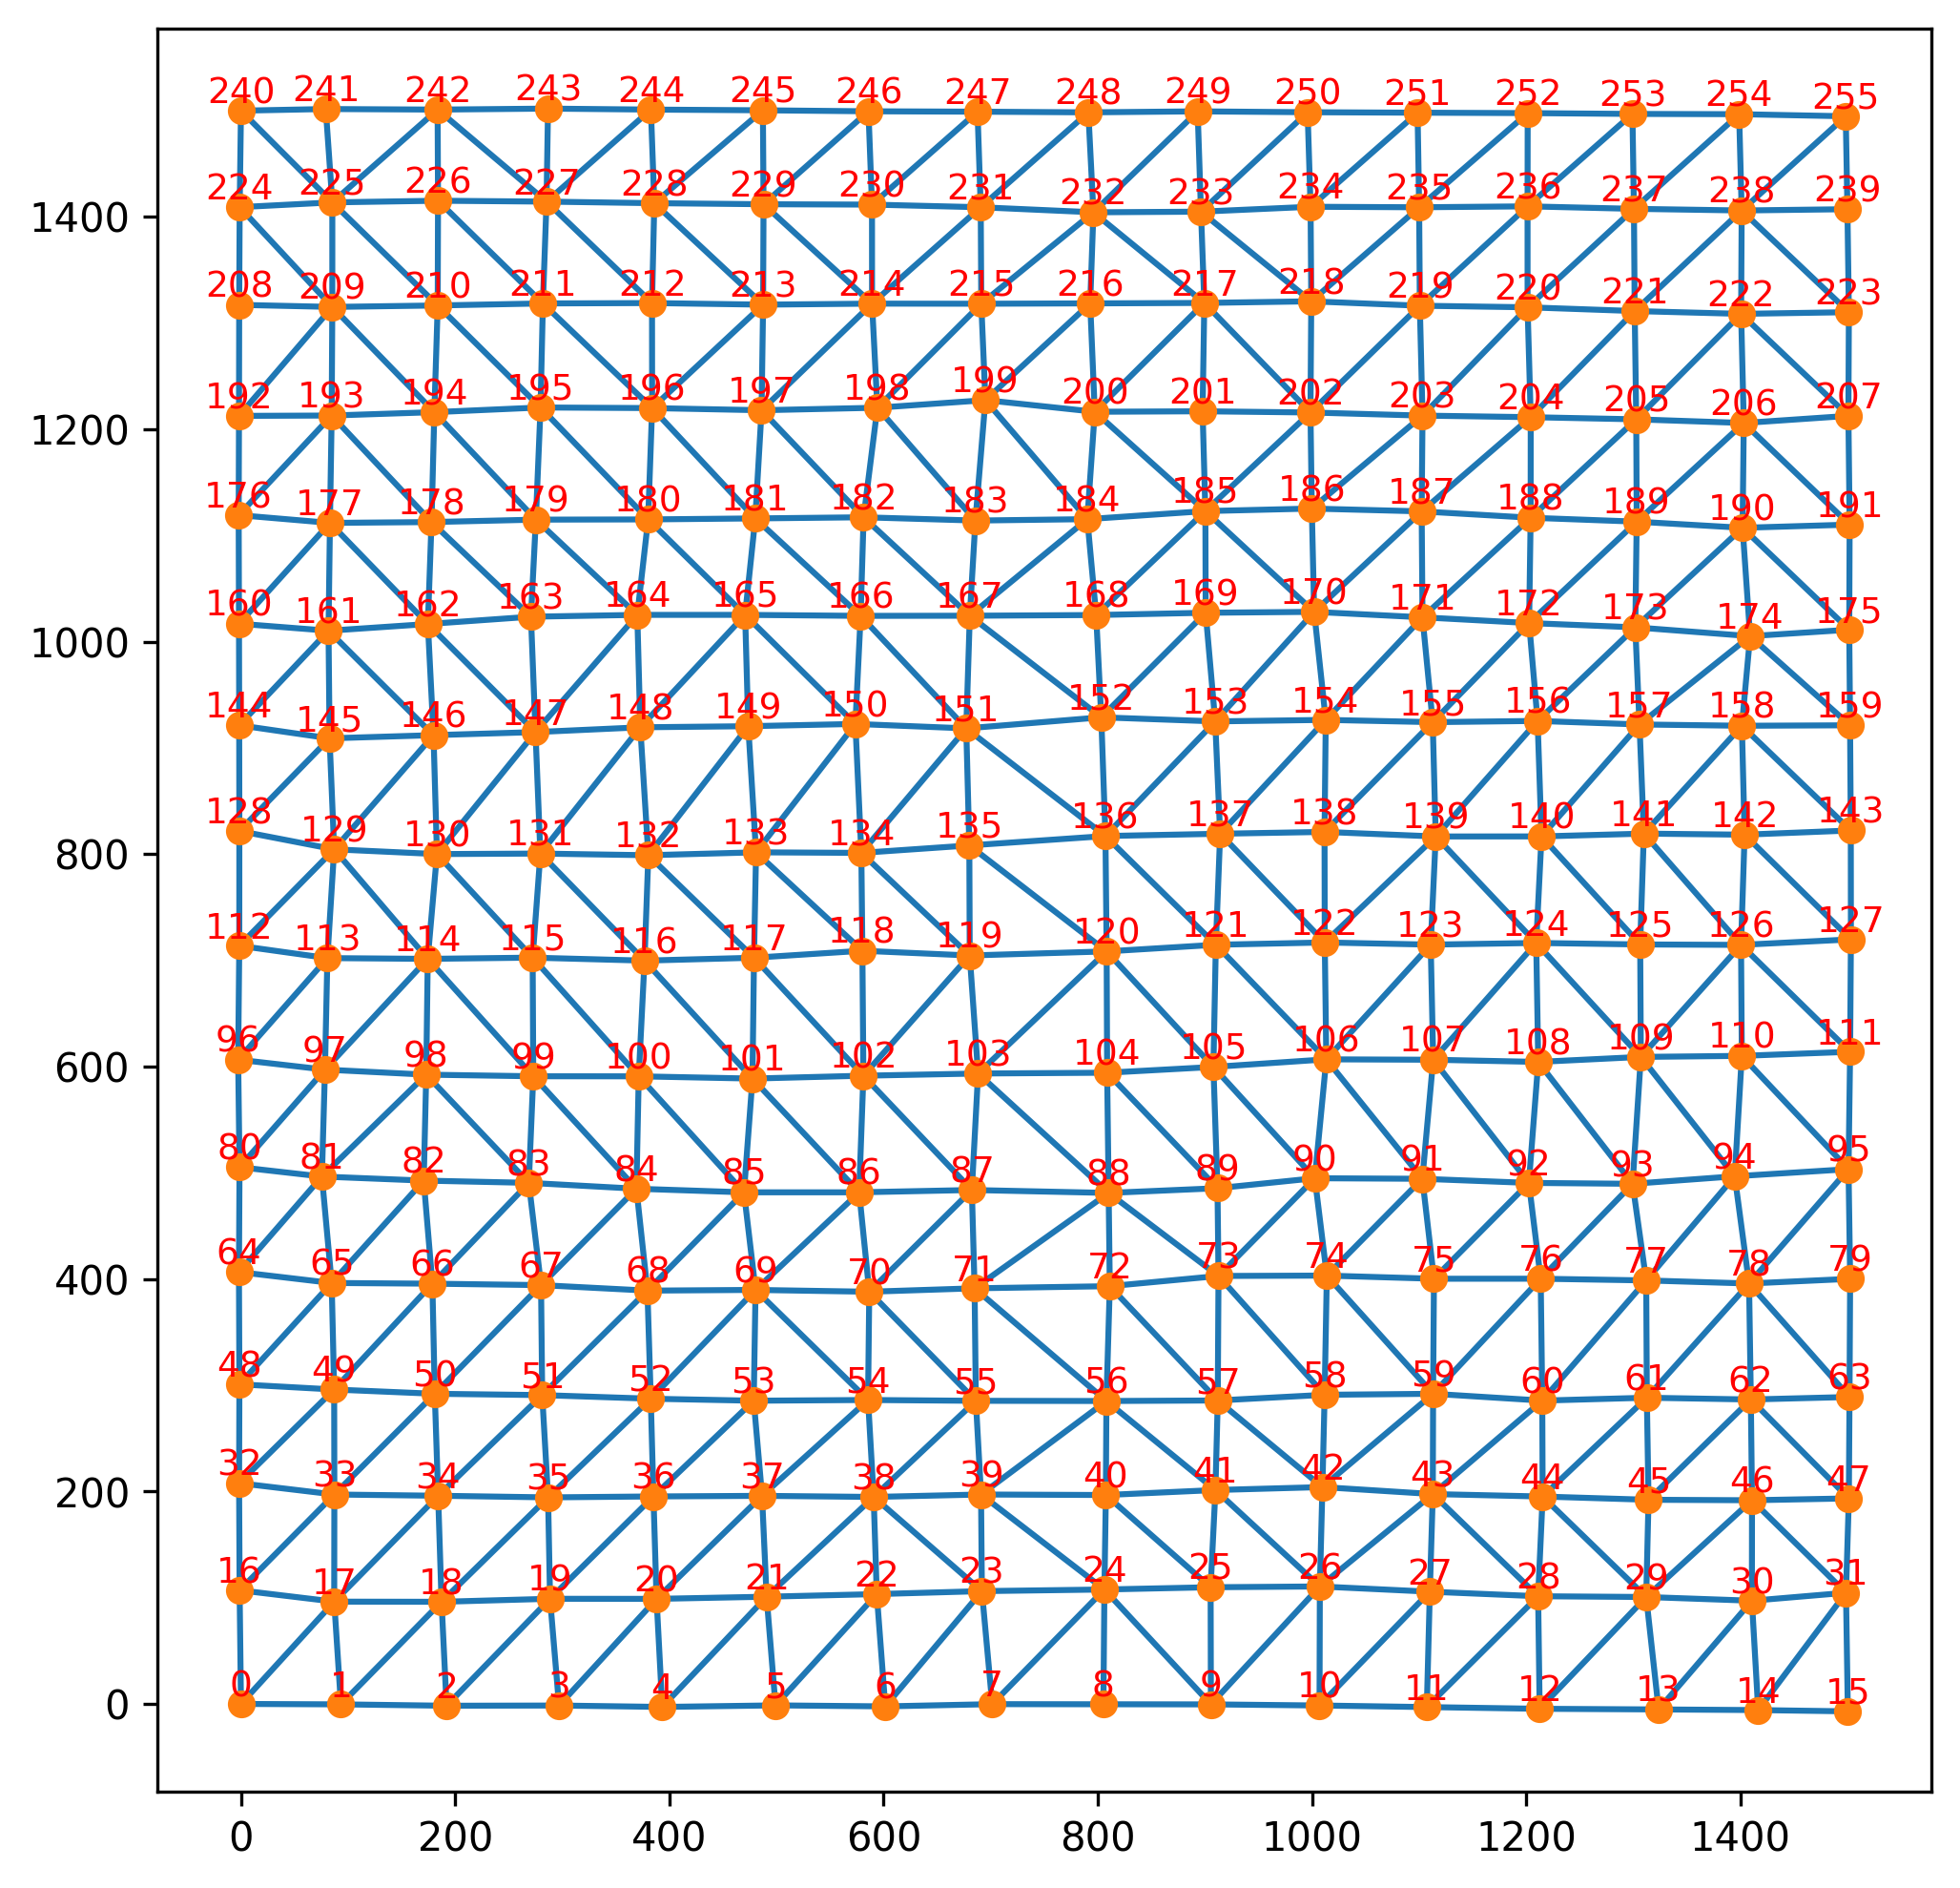

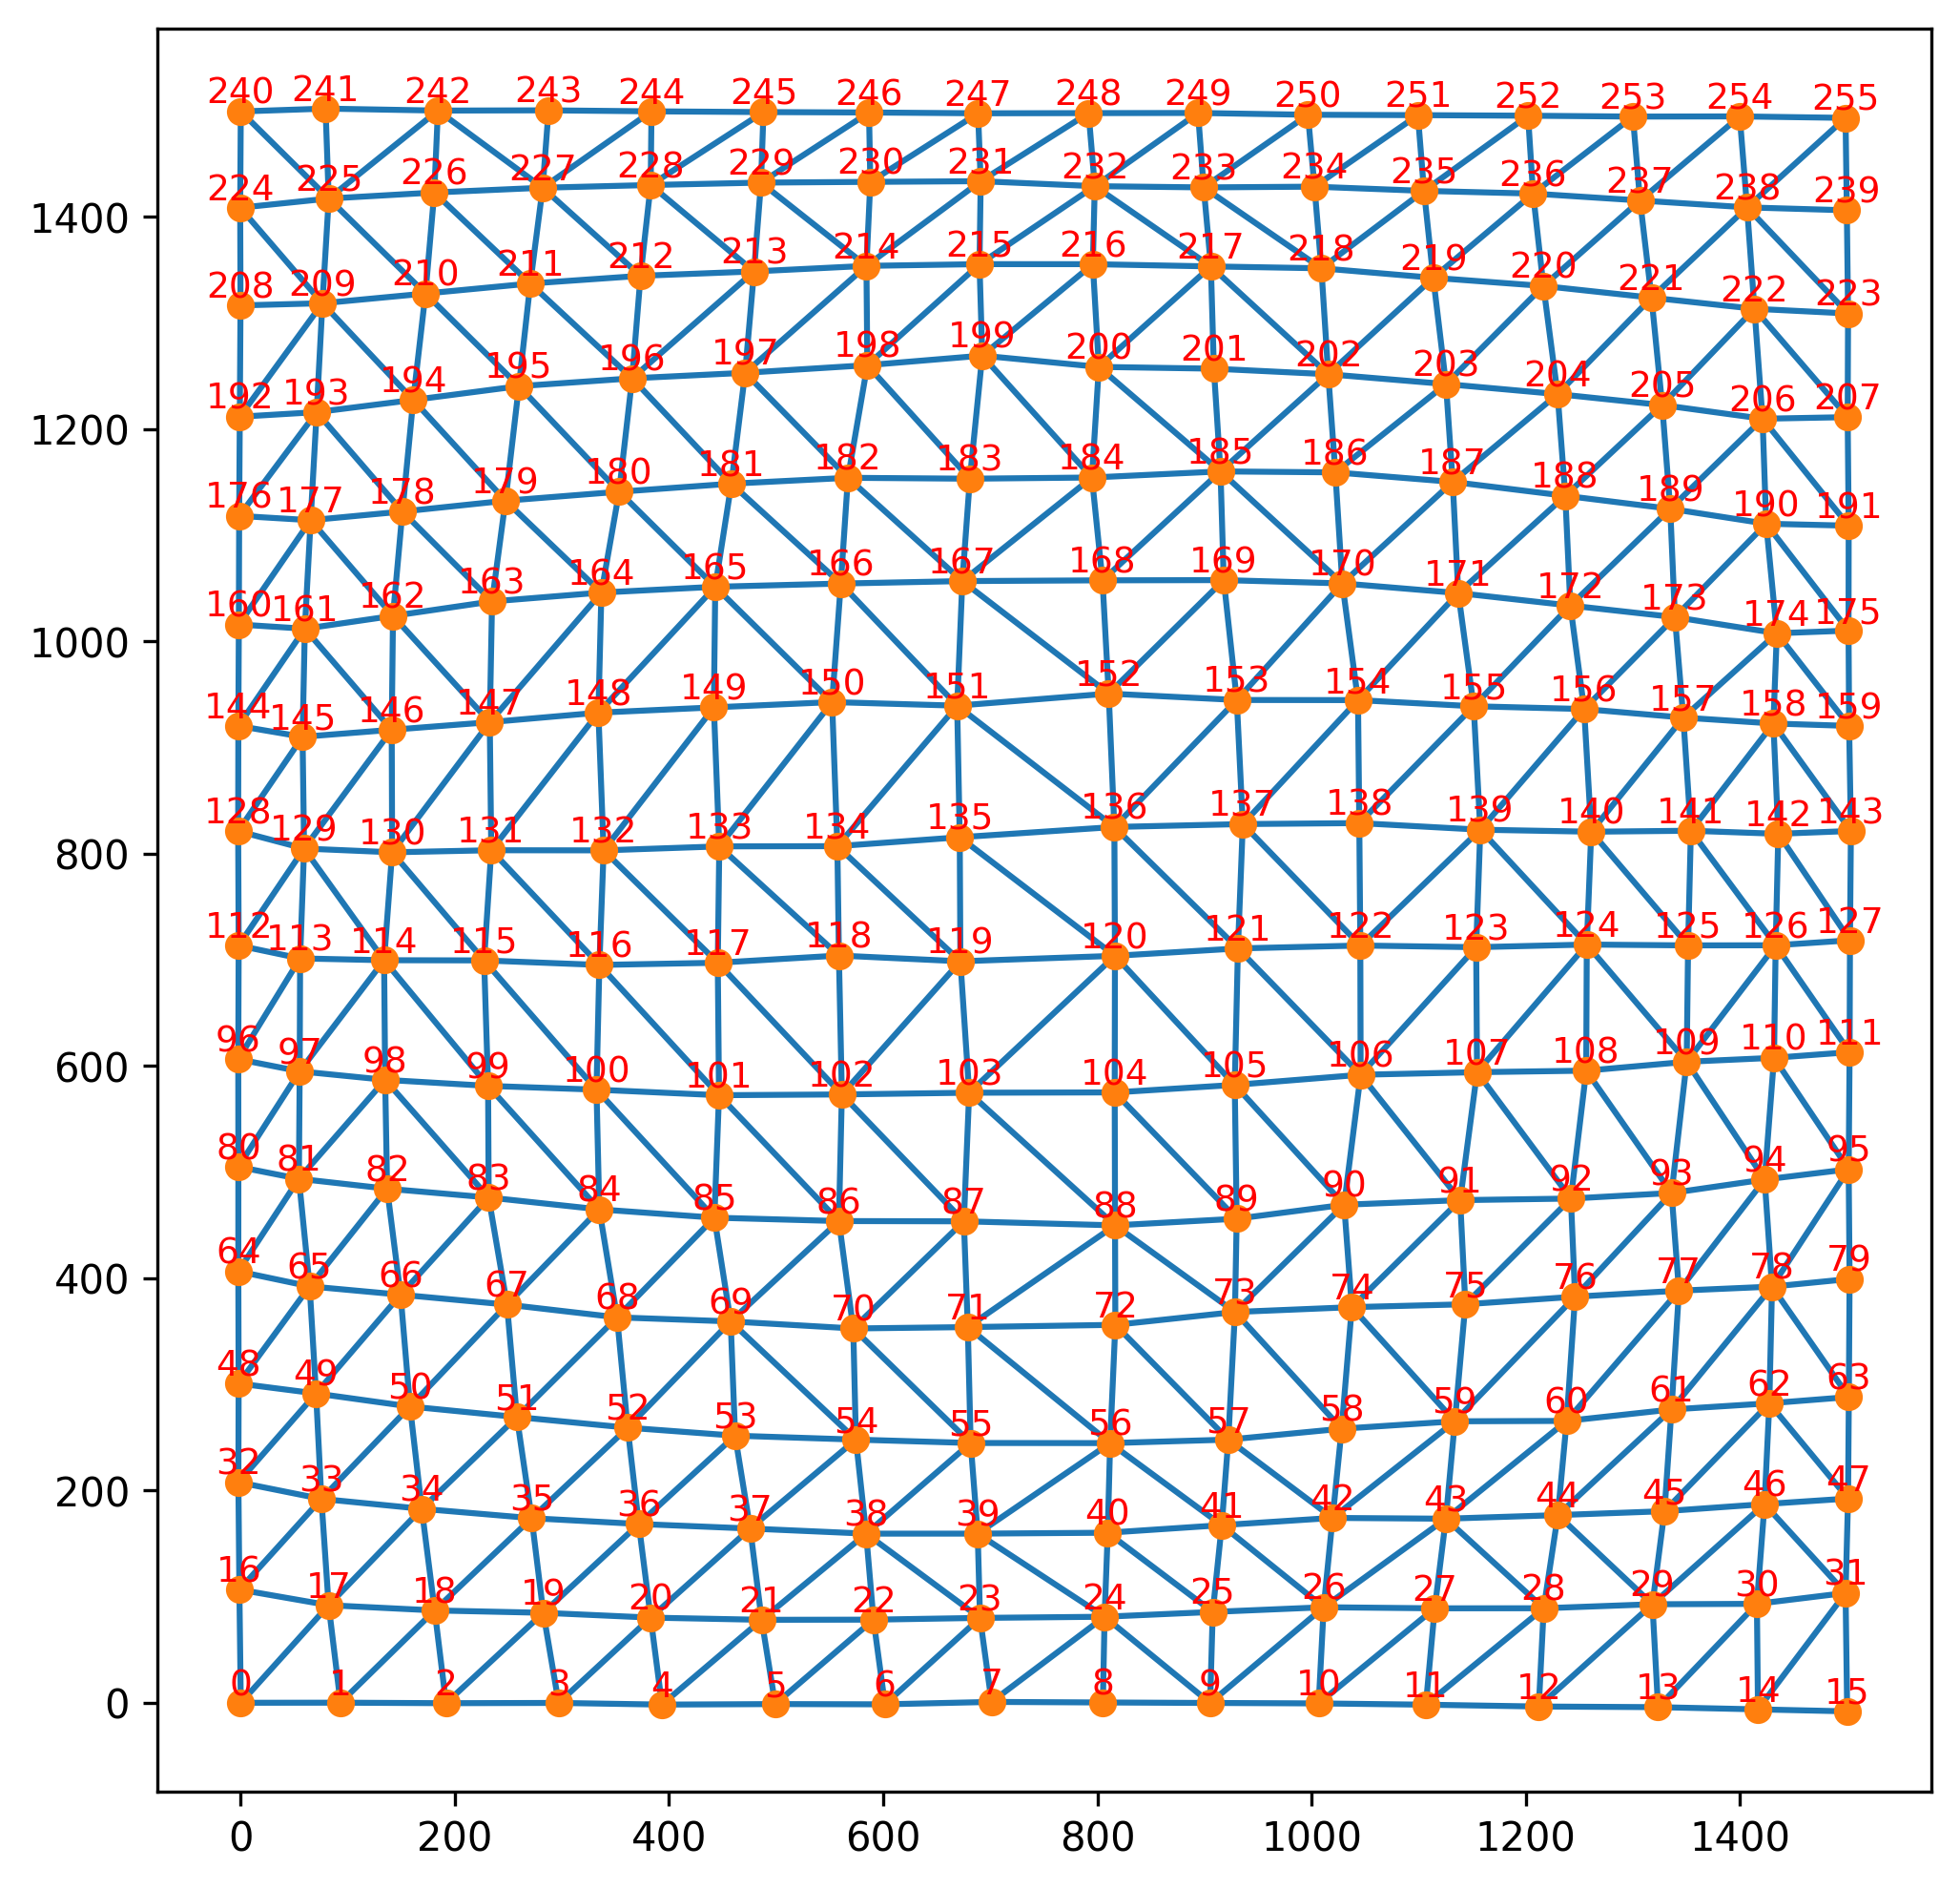

In [4]:
# 3 The point clouds is triangulated to obtain the relation between the element and the nodes
# 3.1 Triangulation of the point cloud before deformation
import matplotlib.tri as mtri
from matplotlib.tri import Triangulation, LinearTriInterpolator

xy = np.array(points.iloc[:, [1,2]])
triang = mtri.Triangulation(xy[:,0], xy[:,1])
element_nodes = triang.triangles

# Delete the narrow triangles near the boundary
import math
distance = 100 # Distance between targets
s = 1.3 # Scaling of the distance, adjusting the parameter until the number of cells in element_nodes_new is equal to the theoretical value
node0 = element_nodes[:, 0] # The first node of the triangular unit
node1 = element_nodes[:, 1] # The second node of the triangular unit
node2 = element_nodes[:, 2] # The third node of the triangular unit
I = []

for i in range(element_nodes.shape[0]):
    x0_x1 = abs(points['point_x'][node0[i]] - points['point_x'][node1[i]])
    y0_y1 = abs(points['point_y'][node0[i]] - points['point_y'][node1[i]])
    x1_x2 = abs(points['point_x'][node1[i]] - points['point_x'][node2[i]])
    y1_y2 = abs(points['point_y'][node1[i]] - points['point_y'][node2[i]])
    x0_x2 = abs(points['point_x'][node0[i]] - points['point_x'][node2[i]])
    y0_y2 = abs(points['point_y'][node0[i]] - points['point_y'][node2[i]])
    if x0_x1>distance*s or y0_y1>distance*s or x1_x2>distance*s or y1_y2>distance*s \
        or x0_x2>distance*s or y0_y2>distance*s :
        I.append(i)
    else:
        pass
element_nodes = np.delete(element_nodes, I, axis=0) # Remove the narrow triangles at the boundary points in the triangulation result
triang = mtri.Triangulation(xy[:,0], xy[:,1], element_nodes)

plt.figure(dpi=300, figsize=(8,8))
plt.triplot(triang, marker="o") # Plot the updated 2D triangular results

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points['point_ID'][i],
            fontsize = 9,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom') # Showing point numbers on the updated triangulation result plot

# 3.2 Triangulation of the point cloud after deformation
node_deformed = points_deformed.iloc[:, [1,2]]
xy_deformed = np.array(node_deformed)
triang_deformed = mtri.Triangulation(xy_deformed[:,0], xy_deformed[:,1], element_nodes)

plt.figure(dpi=300, figsize=(8,8))
plt.triplot(triang_deformed, marker="o") # Plot the 2D triangular results

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 9,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom') # Display of point numbers on the resultant plot of the triangular

In [5]:
# 4 Calculate the displacements of deformed points
def find_displacement(ID):
    for i in range(points.shape[0]):
        p_ID = points.loc[i, 'point_ID']
        if ID == p_ID:
            px = points.loc[i, 'point_x']
            py = points.loc[i, 'point_y']
            pz = points.loc[i, 'point_z']
        else:
            pass
    
    for i in range(points_deformed.shape[0]):
        p_ID = points_deformed.loc[i, 'point_ID']
        if ID == p_ID:
            pxd = points_deformed.loc[i, 'point_x']
            pyd = points_deformed.loc[i, 'point_y']
            pzd = points_deformed.loc[i, 'point_z']
        else:
            pass
    
    u1 = pxd - px
    u2 = pyd - py
    u3 = pzd - pz
    u = math.sqrt(u1**2 + u2**2 + u3**2)
    return u, u1, u2, u3

U = []
U1 = []
U2 = []
U3 = []
for i in range(points_deformed.shape[0]):
    ID = points_deformed.loc[i, 'point_ID']
    U.append(find_displacement(ID)[0])
    U1.append(find_displacement(ID)[1])
    U2.append(find_displacement(ID)[2])
    U3.append(find_displacement(ID)[3])

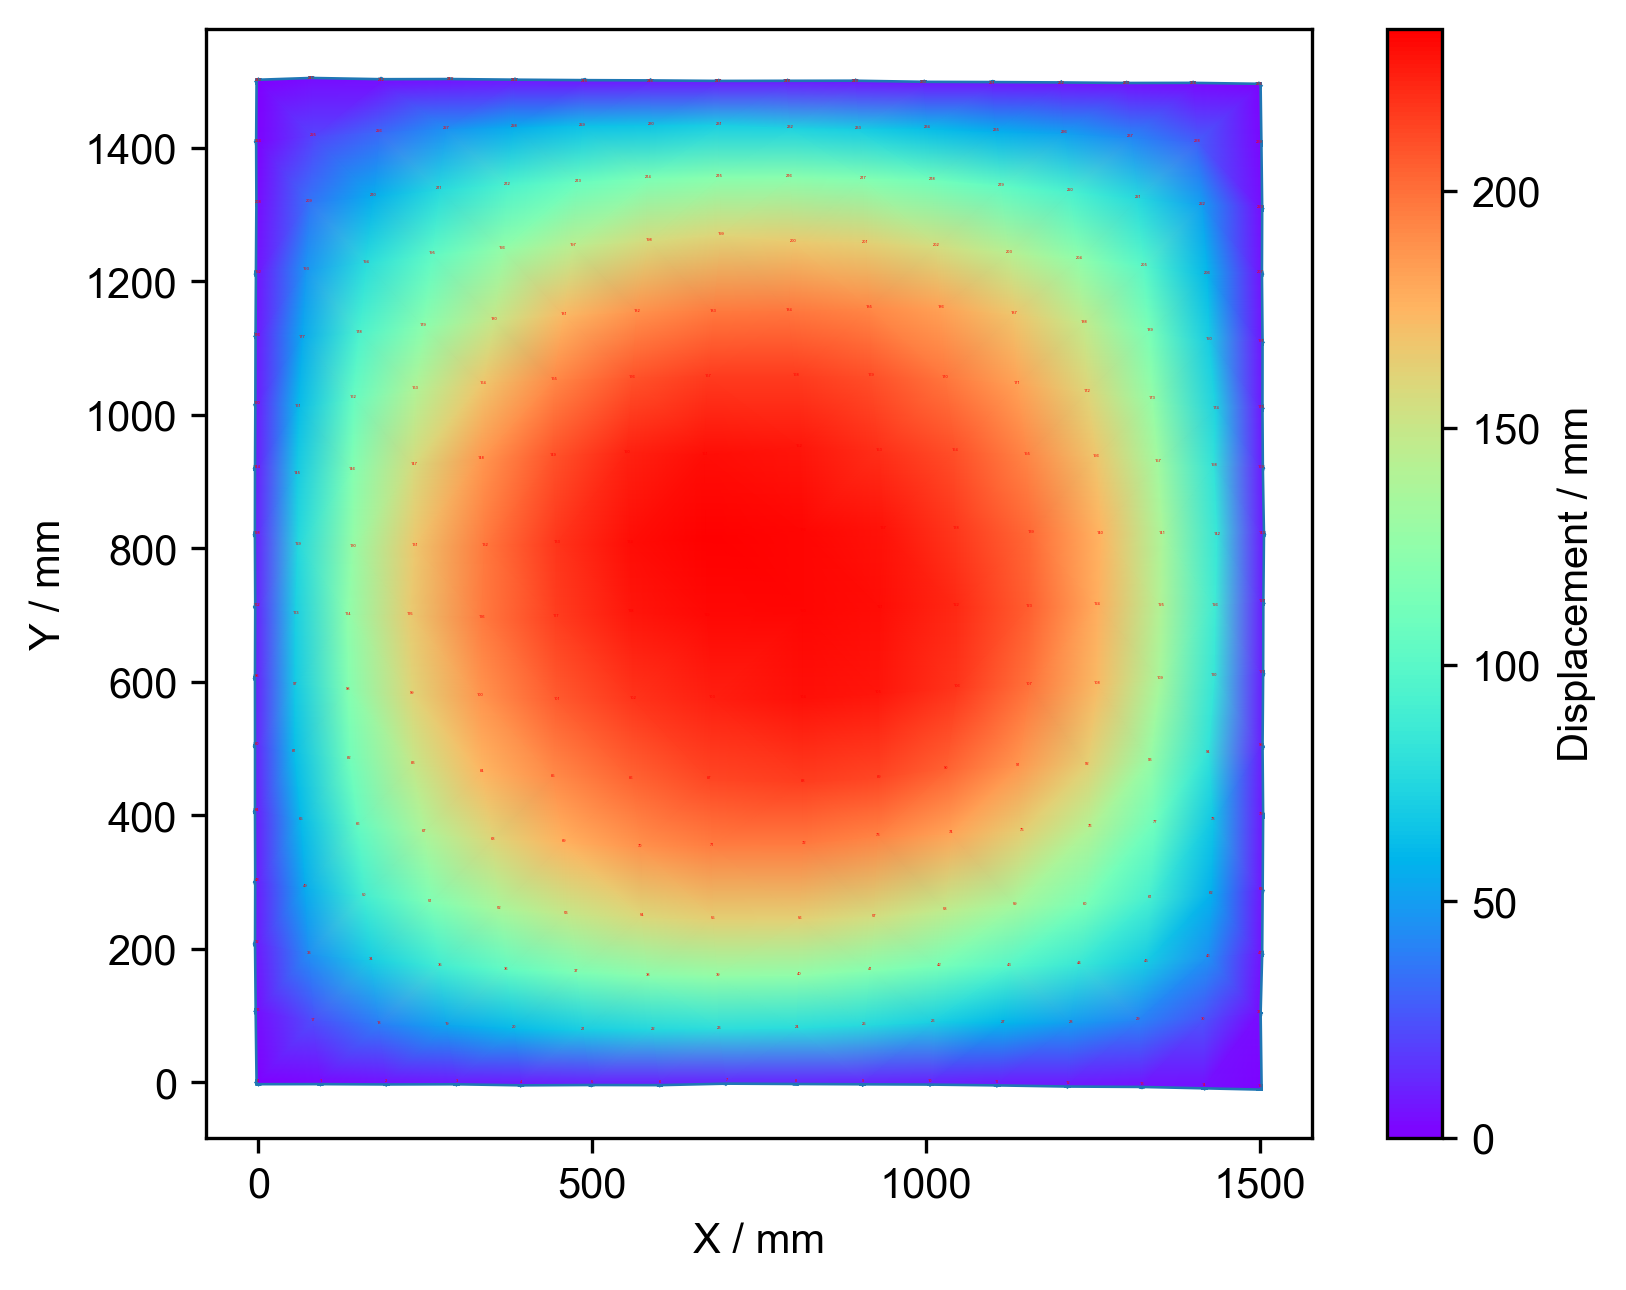

In [6]:
# 5 Plot the displacement values stored on the node
fig = plt.figure(dpi=300)
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.triplot(triang_deformed,)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

cp = plt.tripcolor(triang_deformed, U, cmap='rainbow', shading='gouraud')
#cp.set_clim([0, 330])
plt.colorbar(cp, label="Displacement / mm")

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'

(-77.76611, 1579.12671, -83.58494, 1577.59634)

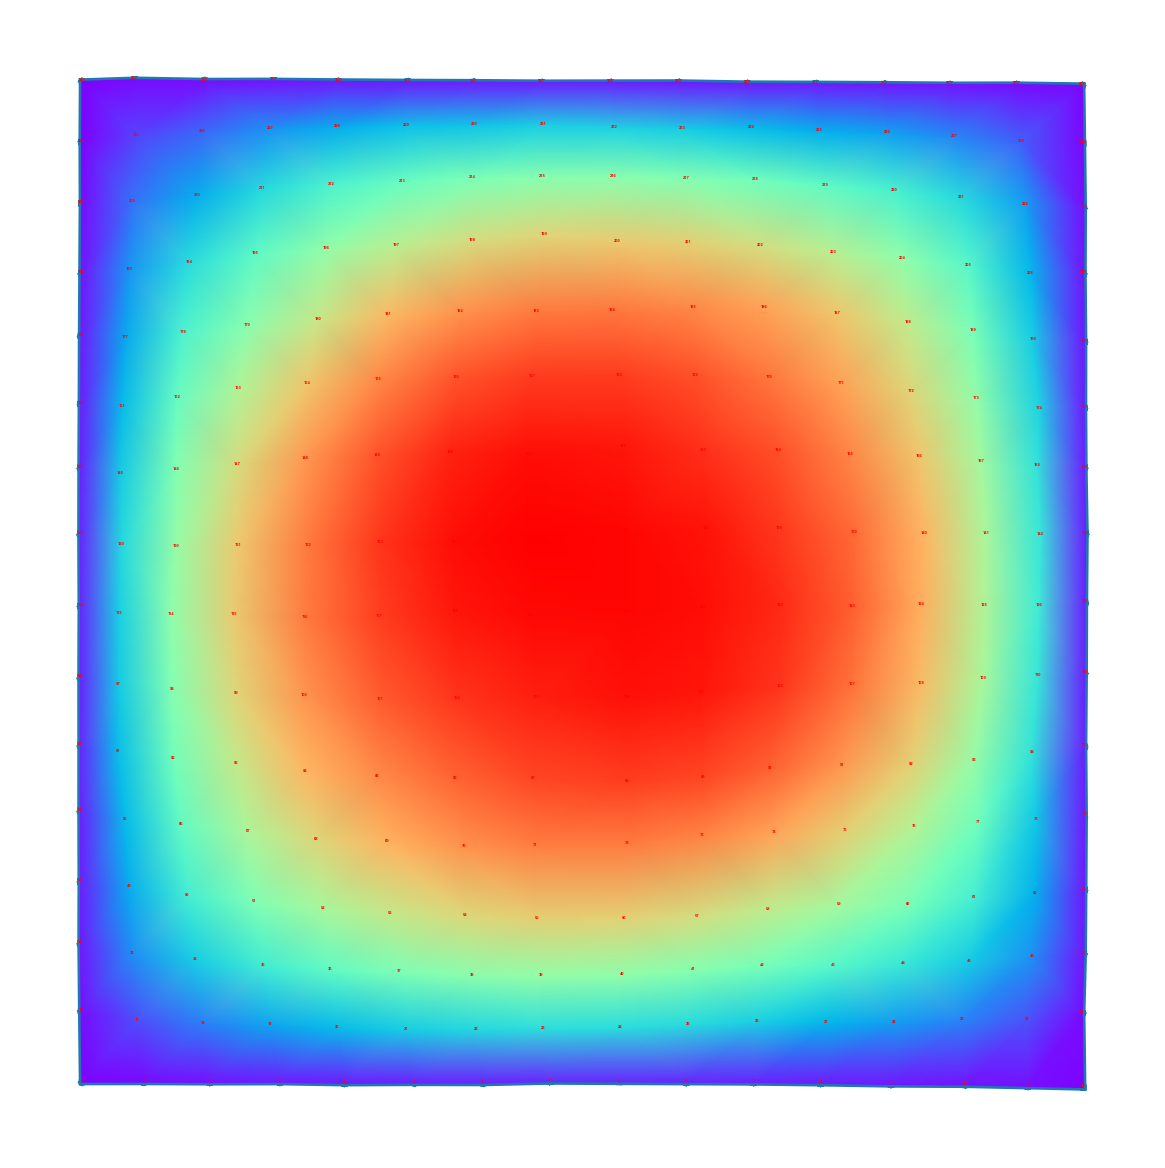

In [7]:
# 6 Plot the displacement values stored on the nodes, delete the axes with the colour bar
fig = plt.figure(dpi=300)
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.triplot(triang_deformed,)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

cp = plt.tripcolor(triang_deformed, U, cmap='rainbow', shading='gouraud')
#cp.set_clim([0, 330])
#plt.colorbar(cp, label="Displacement / mm")

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'

plt.axis('off')